### Algorithm: Metropolis-Hasting Algorithm

Based on my coding, the Metropolis-Hasting Algorithm can be saparater to 2 parts:     
1.__init__  
In this part, we need input "rho" the target distribution of the parameter and "seed" the random see to generater u which is the random variable used to deciding whether to reject the update the paramteter during the prediction.  
2.predict  
In this part, we need input "theta0" the initial state of the parameter which can be the output of the previous prediction, "qProb" the function used to calculate the probability of the proposal value of the parameter with given the previous value of the parameter, "qSamp" the function used to draw the proposal value of the parameter from the proposal distribution of the sample with given the previous value of the parameter and "epoch" the number of round of prediction of the parameter with the Metropolis-Hasting Algorithm.  

In [2]:
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt

class MHMC:  
    def __init__(
    self, 
    rho: Callable, # the target distribution of the parameter
    seed=123 # setting the random seed of the distribution
    ) -> None:
        np.random.seed(seed)
        self.rho = rho

    def predict(
        self,
        theta0: List[int], # the initial value of the parameter
        qProb: Callable, # probability of the proposal distribution of the parameter
        qSamp: Callable, # draw the sample with the proposal distribution
        epoch: int # trian the MCMC for n epoch
    ) -> List[int]:
        self.qProb = qProb
        self.qSamp = qSamp
        theta_n = theta0
        for i in range(0, epoch):
            # Updating the parameter from the proposal disribution
            theta_nPlus1 = self.qSamp(theta_n)
            alpha = min(1, (self.rho(theta_nPlus1)*self.qProb(theta_nPlus1,theta_n))/(self.rho(theta_n)*self.qProb(theta_n,theta_nPlus1)))
            # Deciding whether to reject the update of the parameter
            u = np.random.default_rng().uniform(0, 1, 1)[0]
            if(alpha>=u):
                theta_n = theta_nPlus1
            else:
                pass
        return theta_n

In [22]:
from typing import Optional
import numpy as np

class UniformProposalDistribution:
    def __init__(
        self, 
        radius: float,
        Dim: float
    ) -> None:
        self.radius = radius
        self.Dim = Dim
    
    def qProb(self, theta_nPlus1: List[float], theta_n: List[float]) -> float:
        return (1/(2*self.radius))**self.Dim
    
    def qSample(self, theta: List[float]) -> List[float]:
        return [np.random.uniform(low=t-self.radius, high=t+self.radius, size=1)[0] for t in theta]

### Alogrithm: Hamiltonian Monte Carlo Alforithm

Since  
$$U(\theta) = -log(\rho(\theta)),$$
where $\rho(\theta)$ is the probability distribution of the parameter $\theta$.  
Then  
$$\frac{dU(\theta)}{d\theta} = -\frac{\rho'(\theta)}{\rho(\theta)}$$

In [23]:
from typing import List, Callable
import numpy as np
class HMC:
    def __init__(
        self,
        rho: Callable, # the target distribution of the parameter
        drho_dtheta: List[Callable], # the derivative of the target distribution
    ) -> None:
        self.rho = rho
        self.drho_dtheta = drho_dtheta

    def U(
        self,
        theta: List[float]
    ) -> float: # the potential energy function: U(theta) = -log(probability distribution of theta)
        return - np.log(self.rho(theta))
    
    def dU_dtheta(
        self,
        theta: List[float]
    ) -> float: # the derivative of the potential energy function
    
        return [-(self.rho(theta))/(self.drho_dtheta[i](theta)) for i in range(len(self.drho_dtheta))]


    def predict(
        self,
        theta0: List[float], # initial value of the parameter
        lr: float, # learning rate
        L: int, # the number of leapfrog steps in the trajectory
        epoch: int # trian the MCMC for n epoch
    ):
        theta_n = theta0
        for _ in range(0, epoch):
            theta_nPlus1 = theta_n
            # the ”positions” which are independent standard normal variables
            p_n = np.random.default_rng().normal(0, 1, len(theta_n))
            p_nPlus1 = p_n
            # At the beginning, take a half step for momentum.
            p_nPlus1 = p_nPlus1 - [lr*i/2 for i in self.dU_dtheta(theta_nPlus1)]
            for i in range(0,L):
                # Take a full step for the position
                theta_nPlus1 = theta_nPlus1 + lr*p_nPlus1
                # Unless at the end of the trajectory, take a full step for the momentum
                p_nPlus1 = (p_nPlus1 - [lr*i for i in self.dU_dtheta(theta_nPlus1)]) if (i<(L-1)) else p_nPlus1
            # At the end, take a half step for momentum.
            p_nPlus1 = p_nPlus1 - [lr*i for i in self.dU_dtheta(theta_nPlus1)]
            # To make the proposal symmetric, negate momentum at end of trajectory
            p_nPlus1 = -p_nPlus1
            # At start and end of trajectory, evaluate potential and kinetic energies
            u_n = self.U(theta_n)
            k_n = 0
            for pValue in p_n:
                k_n += pValue**2
            k_n /= 2
            u_nPlus1 = self.U(theta_nPlus1)
            k_nPlus1= 0
            for pValue in p_nPlus1:
                k_nPlus1 += pValue**2
            k_nPlus1 /= 2
            # At end of trajectory deciding whether accept or reject the state , returning either the position at the end of the trajectory or the initial position
            alpha = np.exp(u_n-u_nPlus1+k_n-k_nPlus1)
            u = np.random.default_rng().uniform(0, 1, 1)[0]
            if(alpha>u):
                theta_n = theta_nPlus1
            else:
                pass
        return theta_n

### Visualizing

#### Gaussian Distribution

Let $\left( \begin{array}{c} x_1 \\ x_2 \end{array}\right)$ $\sim$ $N(\left( \begin{array}{c} \mu_1 \\ \mu_2 \end{array}\right),\left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right))$.  
Then  
$$f(x_1, x_2| \mu_1, \mu_2) = \prod_{i=1}^2 \frac{exp(-\frac{(x_i - \mu_i)^2}{2})}{\sqrt{2\pi}}$$
If we have data $data:= \{(x_{1,i}, x_{2, i})\}_{i = 1, 2, 3, ..., n}$ from the distribution $N(\left( \begin{array}{c} 2 \\ 2 \end{array}\right),\left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right))$.  
Then the likelihood function of the data above is  
$$L(\mu_1, \mu_2) = \prod_{i=1}^n f(x_{1, i}, x_{2, i}| \mu_1, \mu_2)$$
By partial derivating $L$ respect to $\mu_i$
$$\frac{\partial L(\mu_1, \mu_2)}{\mu_i} = (x_i - \mu_i) \prod_{i=1}^n f(x_{1, i}, x_{2, i}| \mu_1, \mu_2)$$

In [102]:
import numpy as np
from typing import List, Callable

class Likelihood_Gaussian:
    def __init__(self, Dim:int, Dataset: List[List[float]]) -> None:
        self.Dim = Dim
        self.Dataset = Dataset
    
    def f(self, x: List[float], mu: List[float]) -> float:
        res = 1
        for i in  range(0, self.Dim):
            res *= (np.exp(-((x[i]-mu[i])**2)/2))/(np.sqrt(2*np.pi))
        return res

    def L(self, mu: List[float]) -> float:
        res = 1
        for i in range(len(self.Dataset)):
            res *= self.f(self.Dataset[i], mu)
        return res
    
    def dLdmu_i(self, mu: List[float]) -> List[float]:
        res = 1
        for k in range(len(self.Dataset)):
            res *= self.f(self.Dataset[k], mu)
        for k in range(len(self.Dataset)):
            res *= (self.Dataset[k][self.i]-mu[self.i])
        return res

    def dLdmu_iGen(self, i: int) -> Callable:
        self.i = i
        return self.dLdmu_i

##### Preparing data

Generating 100 datapoints from the distribution $N(\left( \begin{array}{c} 2 \\ 2 \end{array}\right),\left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}\right))$.  

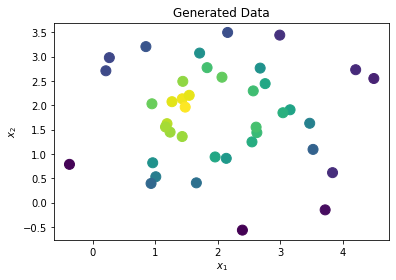

/opt/anaconda3/envs/PyTorchTest/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


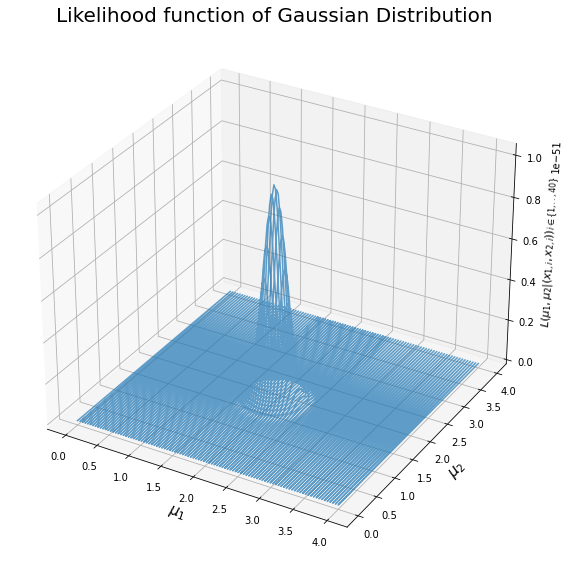

In [134]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

Dataset = []
for _ in range(0,40):
    Dataset.append(list(np.random.default_rng().normal(2, 1, 2)))

x1 = [p[0] for p in Dataset]
x2 = [p[1] for p in Dataset]
x1x2 = np.vstack([x1,x2])
z = gaussian_kde(x1x2)(x1x2)
plt.scatter(x1, x2, c=z, s=100)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Generated Data")
plt.show()

Likeli = Likelihood_Gaussian(Dim=2, Dataset=Dataset)
Grid = np.linspace(0, 4, 100)
x = []
y = []
z = []
r = len(Grid)
for g in Grid:
    y += list(Grid)
    x += [g]*r
    z += [Likeli.L([g, k]) for k in Grid]
fig = plt.figure(figsize=(8, 8), facecolor="white")
Gau = fig.add_subplot(projection="3d")
Gau.plot(x, y, z, alpha=0.7)
Gau.set_xlabel("$\mu_1$", fontsize=15)
Gau.set_ylabel("$\mu_2$", fontsize=15)
Gau.set_zlabel("$L(\mu_1, \mu_2| {(x_{1,i}, x_{2,i})})_{i \in \{1,..,40\}}$", fontsize=11)
Gau.set_title("Likelihood function of Gaussian Distribution", fontsize=20)
fig.tight_layout()
fig.show()


In [120]:
q = UniformProposalDistribution(0.01, Dim=2)
MetropolisHasting = MHMC(rho=Likeli.L)
MetropolisHasting.predict(theta0=[0,0], qProb=q.qProb, qSamp=q.qSample, epoch=10000)

[1.8588816390318847, 2.0809450169441326]

In [146]:
Hamiltonian = HMC(rho=Likeli.L, drho_dtheta=[Likeli.dLdmu_iGen(i) for i in range(0, 2)])
Hamiltonian.predict(
    [0, 0],
    2e-3,
    5,
    8000
)

/opt/anaconda3/envs/PyTorchTest/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


array([1.91643606, 0.59808866])